In [1]:
import ROOT
from ROOT import TMVA

Welcome to JupyROOT 6.22/08


## Declare factory 

In [2]:
ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Input data

In [3]:
data_input = "data_ntuple.root"
MC_input = "MC_ntuple.root"

data_file = ROOT.TFile.Open(data_input)
MC_file = ROOT.TFile.Open(MC_input)
# retrieve input trees

signalTree     = MC_file.Get("ntupleTree")
backgroundTree = data_file.Get("ntupleTree")

signalTree.Print()
# backgroundTree.Print()


******************************************************************************
*Tree    :ntupleTree: ntupleTree                                             *
*Entries :    33027 : Total =        84839065 bytes  File  Size =    8394135 *
*        :          : Tree compression factor =  10.13                       *
******************************************************************************
*Br    0 :hltNames  : vector<string>                                         *
*Entries :    33027 : Total  Size=   60024005 bytes  File Size  =    3025026 *
*Baskets :     1943 : Basket Size=      32000 bytes  Compression=  19.83     *
*............................................................................*
*Br    1 :hltResults : vector<bool>                                          *
*Entries :    33027 : Total  Size=    2851085 bytes  File Size  =     342595 *
*Baskets :       94 : Basket Size=      32000 bytes  Compression=   8.32     *
*...................................................

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree,     signalWeight     )
loader.AddBackgroundTree( backgroundTree, backgroundWeight )

## Define input variables 

loader.AddVariable("Dimuon_CL")
loader.AddVariable("Dimuon_LS")
loader.AddVariable("Dimuon_CosAlpha")
loader.AddVariable("B_Eta")
loader.AddVariable("Bz_LS")
loader.AddVariable("Bz_CL")
loader.AddVariable("Bz_CosAlpha")
loader.AddVariable("Kstar_Mass")
loader.AddVariable("track1_pT")
loader.AddVariable("track1_eta")
loader.AddVariable("track1_d0")
loader.AddVariable("track2_pT")
loader.AddVariable("track2_eta")
loader.AddVariable("track2_d0")
loader.AddVariable("Muon1_pT")
loader.AddVariable("Muon1_eta")
loader.AddVariable("Muon2_pT")
loader.AddVariable("Muon2_eta")

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree ntupleTree of type Signal with 33027 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree ntupleTree of type Background with 943 events


## Optimize the background data:
Filter the events from the data that are from the signal peak region, so that we are sure to only feed pure background to the NN (avoid giving it few signal events in the data)

 FCN=3912.65 FROM MIGRAD    STATUS=CONVERGED     123 CALLS         124 TOTAL
                     EDM=1.52871e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.57220e+03   3.83931e+01   8.19210e-01   7.95080e-07
   2  Mean         5.27325e+00   2.68959e-04   7.72462e-06  -1.48288e-01
   3  Sigma        4.31131e-02   2.58953e-04   2.35450e-05  -2.31270e-02


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


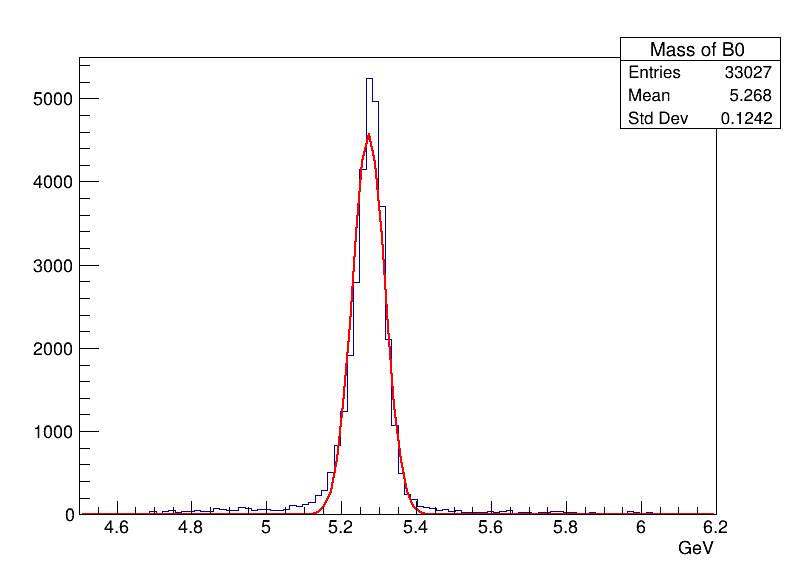

In [5]:
histo_B_mass = ROOT.TH1F("Mass of B0", ";GeV;" , 100, 4.5, 6.2)

for entry in signalTree:
    histo_B_mass.Fill(entry.B_Mass)

histo_B_mass.Fit("gaus")
canvas = ROOT.TCanvas("canvas", "Title", 800, 600)
histo_B_mass.Draw()
canvas.Draw()



## Check the cut 

The range for the peak to discriminate the signal from the background is between 5.230137 and 5.316363


Warning in <TFile::Append>: Replacing existing TH1: Mass of B0 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


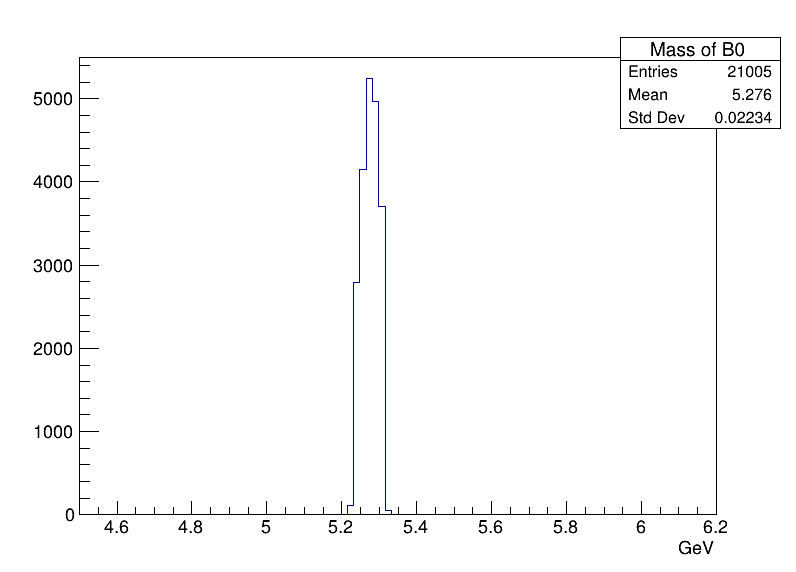

In [6]:
sigma = 4.31131e-02
mean = 5.27325e+00
range1 = mean-sigma
range2 = mean+sigma
histo_B = ROOT.TH1F("Mass of B0", ";GeV;" , 100, 4.5, 6.2)

for entry in signalTree:
    if (entry.B_Mass < range2 and entry.B_Mass > range1):
        histo_B.Fill(entry.B_Mass)

canvas = ROOT.TCanvas("canvas", "Title", 800, 600)
histo_B.Draw()
canvas.Draw()
print ("The range for the peak to discriminate the signal from the background is between %f and %f"%(range1,range2))

## Apply the filter 

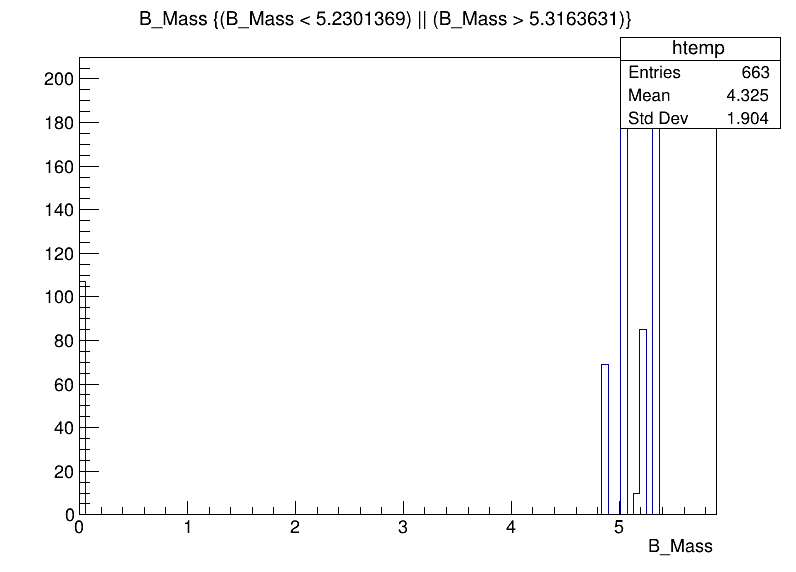

In [7]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")  
mycutb = ROOT.TCut("(B_Mass < 5.2301369) || (B_Mass > 5.3163631)")   ## cut events from the signal region
# mycutb = ROOT.TCut("")

# Check number of events left after the cut 
canvas2 = ROOT.TCanvas("canvas2", "Title", 800, 600)
backgroundTree.Draw("B_Mass", mycutb)
canvas2.Draw()

# Set number of events to train
loader.PrepareTrainingAndTestTree( mycuts, mycutb,
                                  "nTrain_Signal=32084:nTrain_Background=663:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## Booking

In [8]:
## Boosted Decision Trees
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

## Multi-Layer Perceptron (Neural Network)
factory.BookMethod(loader, ROOT.TMVA.Types.kMLP, "MLP",
                   "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

Factory                  : Booking method: BDT
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree ntupleTree
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree ntupleTree
DataSetFactory           : [dataset] : Number of events in input trees
                         : Dataset[dataset] :     Signal     requirement: ""
                         : Dataset[dataset] :     Signal          -- number of events passed: 33027  / sum of weights: 33027
                         : Dataset[dataset] :     Signal          -- efficiency             : 1     
                         : Dataset[dataset] :     Background requirement: "(B_Mass < 5.2301369) || (B_Mass > 5.3163631)"
                         : Dataset[dataset] :     Background      -- number of events passed: 663    / sum of we

## Training 

In [9]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'Dimuon_CL' <---> Output : variable 'Dimuon_CL'
                         : Input : variable 'Dimuon_LS' <---> Output : variable 'Dimuon_LS'
                         : Input : variable 'Dimuon_CosAlpha' <---> Output : variable 'Dimuon_CosAlpha'
                         : Input : variable 'B_Eta' <---> Output : variable 'B_Eta'
                         : Input : variable 'Bz_LS' <---> Output : variable 'Bz_LS'
                         : Input : variable 'Bz_CL' <---> Output : variable 'Bz_CL'
                         : Input : variable 'Bz_CosAlpha' <---> Output : variable 'Bz_CosAlpha'
                         : Input : variable 'Kstar_Mass' <---> Output : variable 'Kstar_Mass'
                         : Input : va

## Testing 

In [10]:
factory.TestAllMethods();   

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (943 events)
                         : Elapsed time for evaluation of 943 events: 0.0038 sec       
Factory                  : Test method: MLP for Classification performance
                         : 
MLP                      : [dataset] : Evaluation of MLP on testing sample (943 events)
                         : Elapsed time for evaluation of 943 events: 0.00459 sec       


## Evaluation 

In [11]:
factory.EvaluateAllMethods();

runtime_error: void TMVA::Factory::EvaluateAllMethods() =>
    runtime_error: FATAL error

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
<FATAL>                         : Number of entries <= 0 (0 in histogram: MVA_BDT_B)
***> abort program execution


Error in <TMVA::Tools::Mean>: sum of weights <= 0 ?! that's a bit too much of negative event weights :) 


## ROC Curve

In [ ]:
%jsroot on
c1 = factory.GetROCCurve(loader);
c1.Draw();
c1.SaveAs("figures/ROC_Curve.pdf")

In [ ]:
outputFile.Close()

## Draw Histograms of classification 

### BDT 

In [ ]:
f = ROOT.TFile.Open("ClassificationOutput.root", "READ")
f.ls()

directory = f.Get("dataset/Method_BDT/BDT")
directory.ls()

In [ ]:
# Draw histogram for output variables: classification of events
c = ROOT.TCanvas("c", "Title", 800, 600)
histo_bkg = f.Get("dataset/Method_BDT/BDT/MVA_BDT_B")
histo_bkg.SetLineColor(3)
histo_bkg.Draw("")
histo_sig = f.Get("dataset/Method_BDT/BDT/MVA_BDT_S")
histo_sig.Draw("same")
histo_bkg.SetTitle("BDT Classification of events")
histo_bkg.SetName("Event Classification")
histo_sig.SetName("Event Classification")
histo_bkg.Write("Event Classification",ROOT.TObject.kWriteDelete);
legend = ROOT.TLegend(0.05,0.80,0.2,0.93)
legend.AddEntry(histo_bkg,"Background", "l")
legend.AddEntry(histo_sig,"Signal", "l")
legend.Draw()
c.Draw()
c.SaveAs("figures/BDT/MVA_BDT.pdf")

# Background 
c1 = ROOT.TCanvas("c1", "Title", 800, 600)
histo_bkg.Draw()
c1.Draw()
c1.SaveAs("figures/BDT/MVA_BDT_B.pdf")

# Signal 
c2 = ROOT.TCanvas("c2", "Title", 800, 600)
histo_sig.Draw()
c2.Draw()
c2.SaveAs("figures/BDT/MVA_BDT_S.pdf")

In [ ]:
c3 = ROOT.TCanvas("c3", "Title", 800, 600)
histo_eff_B = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effB")
histo_eff_S = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effS")
# histoKstar_B.Draw()
histo_eff_B.Draw("")
c3.Draw()
c3.SaveAs("figures/BDT/efficiencyS.pdf")

In [ ]:
c4 = ROOT.TCanvas("c4", "Title", 800, 600)
histo_eff_B = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effB")
histo_eff_S = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effS")
# histoKstar_B.Draw()
histo_eff_B.Draw("")
c3.Draw()
c3.SaveAs("figures/BDT/efficiencyS.pdf")

### MLP

In [ ]:
f2 = ROOT.TFile.Open("ClassificationOutput.root", "READ")
f2.ls()

directory = f2.Get("dataset/Method_MLP/MLP")
directory.ls()

In [ ]:
# Draw histogram for output variables: classification of events
c4 = ROOT.TCanvas("c4", "Title", 800, 600)
h_bkg = f2.Get("dataset/Method_MLP/MLP/MVA_MLP_B")
h_bkg.SetLineColor(3)
h_bkg.Draw("")
h_sig = f2.Get("dataset/Method_MLP/MLP/MVA_MLP_S")
h_sig.Draw("same")
h_bkg.SetTitle("MLP Classification of events")
h_bkg.SetName("Event Classification")
h_sig.SetName("Event Classification")
h_bkg.Write("Event Classification", ROOT.TObject.kWriteDelete);
legend = ROOT.TLegend(0.05,0.80,0.2,0.93)
legend.AddEntry(h_bkg,"Background", "l")
legend.AddEntry(h_sig,"Signal", "l")
legend.Draw()
c4.Draw()
c4.SaveAs("figures/MLP/MVA_MLP.pdf")

# Background 
c5 = ROOT.TCanvas("c5", "Title", 800, 600)
h_bkg.Draw()
c5.Draw()
c5.SaveAs("figures/MLP/MVA_MLP_B.pdf")

# Signal 
c6 = ROOT.TCanvas("c6", "Title", 800, 600)
h_sig.Draw()
c6.Draw()
c6.SaveAs("figures/MLP/MVA_MLP_S.pdf")